[UTKFace dataset](https://www.kaggle.com/datasets/jangedoo/utkface-new) is a large-scale face dataset consisting of over 20,000 images. The images cover a wide range of ages and races and include both males and females. Using this dataset, I will be attempting to create a Multi-Task Learning CNN model to predict the age, gender and ethnicity of an individual.

# ***Import libraries***

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

# ***Load the dataset***

In [2]:
dataset_folder_name = '../input/utkface-new/UTKFace'

In [3]:
dataset_dict = {
    'ethnicity_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['ethnicity_alias'] = dict((r, i) for i, r in dataset_dict['ethnicity_id'].items())

In [4]:
dataset_dict

{'ethnicity_id': {0: 'white',
  1: 'black',
  2: 'asian',
  3: 'indian',
  4: 'others'},
 'gender_id': {0: 'male', 1: 'female'},
 'gender_alias': {'male': 0, 'female': 1},
 'ethnicity_alias': {'white': 0,
  'black': 1,
  'asian': 2,
  'indian': 3,
  'others': 4}}

In [5]:
def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')            
            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['ethnicity_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
def parse_dataset(dataset_path, ext='jpg'):     
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file_path'] = files
    df.columns = ['age', 'gender', 'ethnicity', 'file_path']
    df = df.dropna()
    
    return df

In [6]:
df = parse_dataset(dataset_folder_name)
df['file_name'] = ''
df['file_name'] = df.apply(lambda x : x['file_path'].split('/')[-1], axis = 1)
df.head()

,age,gender,ethnicity,file_path,file_name
0,26.0,male,asian,../input/utkface-new/UTKFace/26_0_2_2017010402...,26_0_2_20170104023102422.jpg.chip.jpg
1,22.0,female,black,../input/utkface-new/UTKFace/22_1_1_2017011223...,22_1_1_20170112233644761.jpg.chip.jpg
2,21.0,female,indian,../input/utkface-new/UTKFace/21_1_3_2017010500...,21_1_3_20170105003215901.jpg.chip.jpg
3,28.0,male,white,../input/utkface-new/UTKFace/28_0_0_2017011718...,28_0_0_20170117180555824.jpg.chip.jpg
4,17.0,female,others,../input/utkface-new/UTKFace/17_1_4_2017010322...,17_1_4_20170103222931966.jpg.chip.jpg


# ***Visualize and Prepare Data***

Text(0, 0.5, 'count')

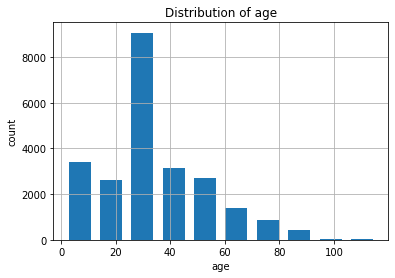

In [7]:
df['age'].hist(rwidth=0.7)
plt.title('Distribution of age')
plt.xlabel('age')
plt.ylabel('count')

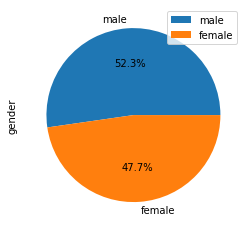

In [8]:
df['gender'].value_counts().plot.pie(autopct="%1.1f%%", labels=['male', 'female'])
plt.legend()

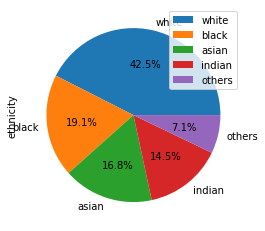

In [9]:
df['ethnicity'].value_counts().plot.pie(autopct="%1.1f%%", labels=['white', 'black', 'asian', 'indian', 'others'])
plt.legend()

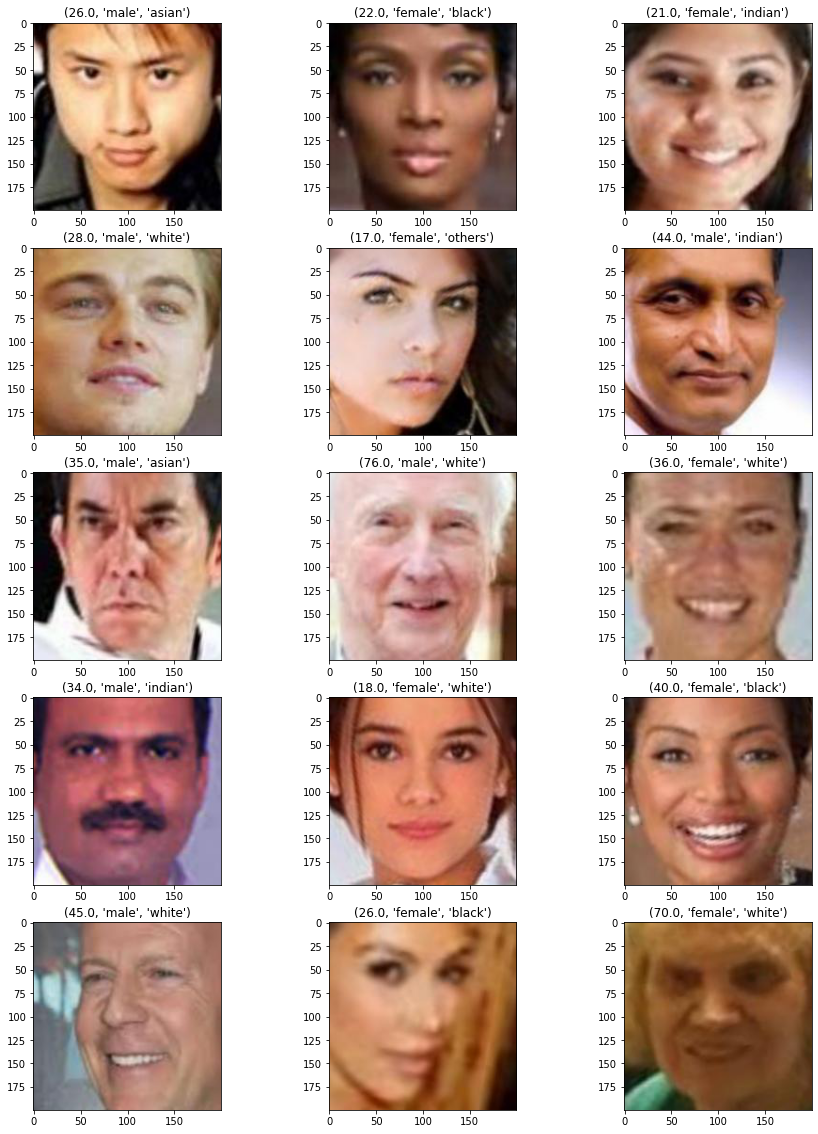

In [10]:
plt.figure(figsize=(15,20))

for i in range(15):
    plt.subplot(5,3,i+1)
    file = df['file_path'][i]
    image = imread(file)
    plt.imshow(image)
    plt.title((df['age'][i], df['gender'][i], df['ethnicity'][i]))

In [11]:
df['gender'] = df.apply(lambda x : dataset_dict['gender_alias'][x['gender']], axis = 1)
df['ethnicity'] = df.apply(lambda x : dataset_dict['ethnicity_alias'][x['ethnicity']], axis = 1)
df.head()

,age,gender,ethnicity,file_path,file_name
0,26.0,0,2,../input/utkface-new/UTKFace/26_0_2_2017010402...,26_0_2_20170104023102422.jpg.chip.jpg
1,22.0,1,1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22_1_1_20170112233644761.jpg.chip.jpg
2,21.0,1,3,../input/utkface-new/UTKFace/21_1_3_2017010500...,21_1_3_20170105003215901.jpg.chip.jpg
3,28.0,0,0,../input/utkface-new/UTKFace/28_0_0_2017011718...,28_0_0_20170117180555824.jpg.chip.jpg
4,17.0,1,4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17_1_4_20170103222931966.jpg.chip.jpg


In [12]:
df = df.astype({'age': int, 'gender': int, 'ethnicity': int, 'file_path': str, 'file_name': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23705 entries, 0 to 23707
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   gender     23705 non-null  int64 
 2   ethnicity  23705 non-null  int64 
 3   file_path  23705 non-null  object
 4   file_name  23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.6+ MB


In [13]:
SPLIT = 0.2

from sklearn.model_selection import train_test_split

training_data, validation_data = train_test_split(df, test_size=SPLIT)

n_train = len(training_data)
n_val = len(validation_data)

print('No. of training image:', n_train)
print('No. of validation image:', n_val)

No. of training image: 18964
No. of validation image: 4741


In [14]:
HEIGHT = WIDTH = 128

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 64

train_generator = train_datagen.flow_from_dataframe(training_data, 
                                                    directory=dataset_folder_name, 
                                                    x_col = 'file_name', 
                                                    y_col = ['age', 'gender', 'ethnicity'], 
                                                    target_size = (HEIGHT, WIDTH),
                                                    class_mode = 'multi_output',
                                                    batch_size = BATCH_SIZE,
                                                    seed = 37)

val_generator = val_datagen.flow_from_dataframe(validation_data, 
                                                directory=dataset_folder_name, 
                                                x_col = 'file_name', 
                                                y_col = ['age', 'gender', 'ethnicity'], 
                                                target_size = (HEIGHT, WIDTH),
                                                class_mode = 'multi_output',
                                                batch_size = BATCH_SIZE,
                                                seed = 37)

Found 18964 validated image filenames.
Found 4741 validated image filenames.


# ***Build the CNN network in a Multi-Task Learning manner***

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf

class MTL_UTK():
    def make_default_hidden_layers(self, inputs):
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        return x  
    
    def build_ethnicity_branch(self, inputs, num_ethnicities):
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_ethnicities)(x)
        x = Activation("softmax", name="ethnicity_output")(x)        
        return x  
    
    def build_gender_branch(self, inputs, num_genders=1): 
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)       
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)        
        return x  
    
    def build_age_branch(self, inputs):            
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)        
        return x 
    
    def assemble_full_model(self, height, width, num_ethnicities):       
        input_shape = (height, width, 3)        
        inputs = Input(shape=input_shape)        
        age_branch = self.build_age_branch(inputs)
        gender_branch = self.build_gender_branch(inputs)
        ethnicity_branch = self.build_ethnicity_branch(inputs, num_ethnicities)        
        model = Model(inputs=inputs,
                     outputs = [age_branch, gender_branch, ethnicity_branch],
                     name="face_net")        
        return model

2023-01-08 23:21:09.274304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 23:21:09.384469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 23:21:09.385340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 23:21:09.386344: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
___________________________________________________________________________________________

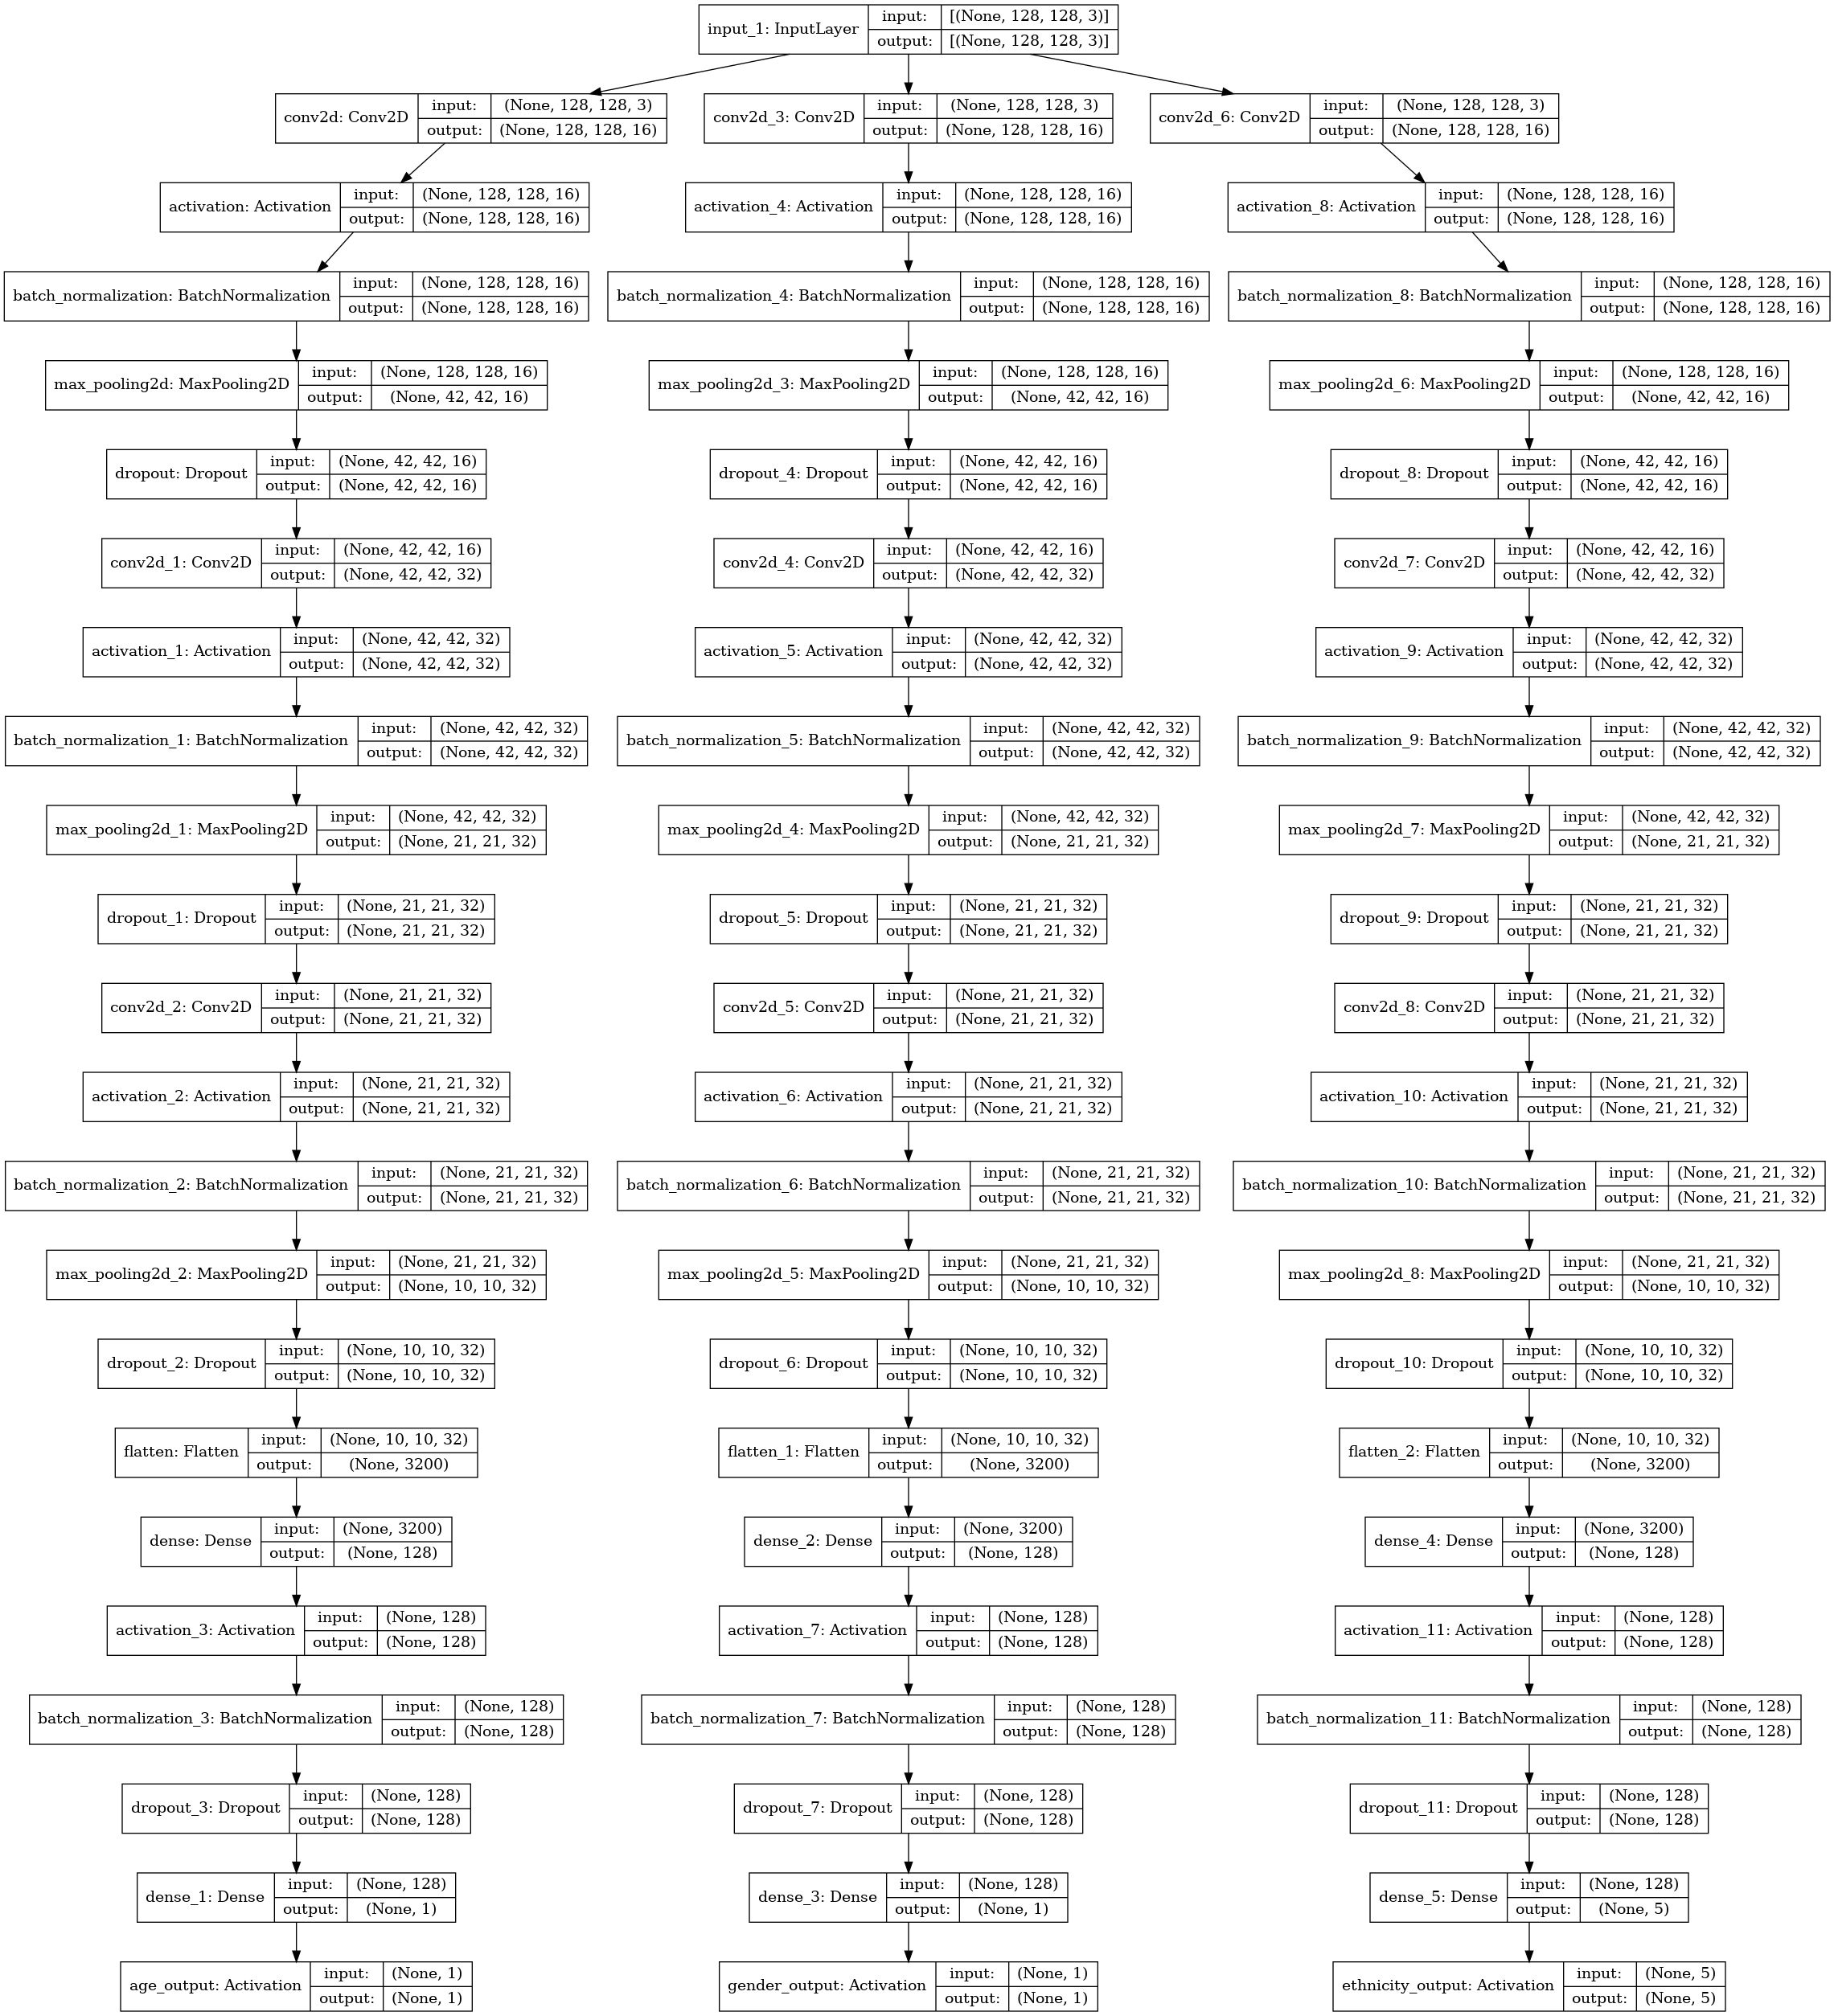

In [16]:
model = MTL_UTK().assemble_full_model(HEIGHT, WIDTH, num_ethnicities=len(dataset_dict['ethnicity_alias']))

model.summary()

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [17]:
init_lr = 1e-4
epochs = 50

In [18]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse',
                  'gender_output': 'binary_crossentropy',
                  'ethnicity_output': 'sparse_categorical_crossentropy'},
              
              loss_weights={
                  'age_output': 4., 
                  'gender_output': 0.1,
                  'ethnicity_output': 1.5},
              
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy',
                  'ethnicity_output': 'accuracy'})

# ***Train the model***

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# earlystopping = EarlyStopping(monitor ="val_loss", 
#                                         mode ="min", patience = 5, 
#                                         restore_best_weights = True)

checkpoint = ModelCheckpoint("Best_model_params.h5", monitor='val_loss')

# callbacks = [checkpoint, earlystopping]
callbacks = [checkpoint]

history = model.fit(train_generator,
                    steps_per_epoch = n_train // BATCH_SIZE, 
                    epochs=epochs,
                    batch_size = BATCH_SIZE,
                    validation_data=val_generator,
                    validation_steps = n_val // BATCH_SIZE,
                    callbacks = callbacks)

2023-01-08 23:21:13.820315: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-01-08 23:21:17.220801: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


296/296 [==============================] - 129s 407ms/step - loss: 5725.3745 - age_output_loss: 1430.5934 - gender_output_loss: 0.6618 - ethnicity_output_loss: 1.9546 - age_output_mae: 33.0124 - gender_output_accuracy: 0.6921 - ethnicity_output_accuracy: 0.3755 - val_loss: 4585.6387 - val_age_output_loss: 1145.6356 - val_gender_output_loss: 0.6941 - val_ethnicity_output_loss: 2.0170 - val_age_output_mae: 28.4467 - val_gender_output_accuracy: 0.5087 - val_ethnicity_output_accuracy: 0.4255
Epoch 2/50
296/296 [==============================] - 42s 141ms/step - loss: 5267.2969 - age_output_loss: 1316.2307 - gender_output_loss: 0.5288 - ethnicity_output_loss: 1.5473 - age_output_mae: 32.5012 - gender_output_accuracy: 0.7624 - ethnicity_output_accuracy: 0.4763 - val_loss: 4882.3115 - val_age_output_loss: 1220.1215 - val_gender_output_loss: 0.4712 - val_ethnicity_output_loss: 1.1869 - val_age_output_mae: 31.0351 - val_gender_output_accuracy: 0.7755 - val_ethnicity_output_accuracy: 0.5543
Epoc

# ***Evaluate the model performance***

Text(0.5, 0, 'epoch')

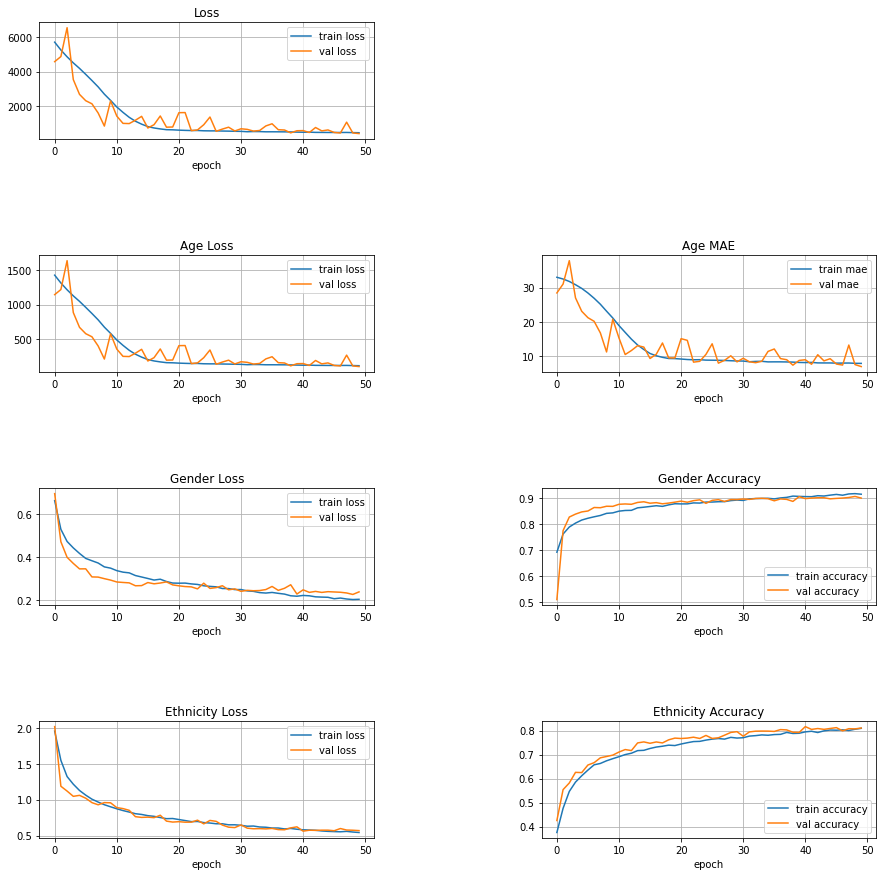

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1)

fig.add_subplot(4,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(4,2,3)
plt.plot(history.history['age_output_loss'], label='train loss')
plt.plot(history.history['val_age_output_loss'], label='val loss')
plt.title('Age Loss')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(4,2,4)
plt.plot(history.history['age_output_mae'], label='train mae')
plt.plot(history.history['val_age_output_mae'], label='val mae')
plt.title('Age MAE')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(4,2,5)
plt.plot(history.history['gender_output_loss'], label='train loss')
plt.plot(history.history['val_gender_output_loss'], label='val loss')
plt.title('Gender Loss')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(4,2,6)
plt.plot(history.history['gender_output_accuracy'], label='train accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='val accuracy')
plt.title('Gender Accuracy')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(4,2,7)
plt.plot(history.history['ethnicity_output_loss'], label='train loss')
plt.plot(history.history['val_ethnicity_output_loss'], label='val loss')
plt.title('Ethnicity Loss')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(4,2,8)
plt.plot(history.history['ethnicity_output_accuracy'], label='train accuracy')
plt.plot(history.history['val_ethnicity_output_accuracy'], label='val accuracy')
plt.title('Ethnicity Accuracy')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')